# import libraries


In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython import display

# define parameters

In [2]:
LOSS = 'binary_crossentropy'
OPTIMIZER_D = tf.keras.optimizers.RMSprop()
OPTIMIZER_A = tf.keras.optimizers.RMSprop()
METRICS = 'accuracy'
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

INPUT_LENGTH = 128
BUFFER_SIZE = 60000

EPOCHS = 10
BATCH_SIZE = 256

INPUT_SHAPE = (28, 28, 1)


# load data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
input_data = np.expand_dims(x_train, axis=-1).astype('float32')
input_data = (input_data)/255.0

print(input_data.shape)
print(np.max(input_data))

(60000, 28, 28, 1)
1.0


In [4]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(input_data).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# define model

### generator

In [5]:
def generator():
    dim = INPUT_SHAPE[0]//4
    depth = 256
    model = tf.keras.models.Sequential()

    model.add(Layers.Dense(dim*dim*depth, use_bias=False, input_dim=INPUT_LENGTH))
    model.add(Layers.BatchNormalization())
    model.add(Layers.LeakyReLU())

    model.add(Layers.Reshape((dim, dim, depth)))

    model.add(Layers.Conv2DTranspose(depth//2, 7, strides=1, padding='same', use_bias=False))
    model.add(Layers.BatchNormalization())
    model.add(Layers.LeakyReLU())

    model.add(Layers.Conv2DTranspose(depth//4, 5, strides=2, padding='same', use_bias=False))
    model.add(Layers.BatchNormalization())
    model.add(Layers.LeakyReLU())

    model.add(Layers.Conv2DTranspose(INPUT_SHAPE[2], 3, strides=2, activation='tanh', padding='same', use_bias=False))

    model.summary()
    return model

### discriminator

In [14]:
def discriminator():
    model = tf.keras.models.Sequential()

    model.add(Layers.Conv2D(64, 5, strides=2, padding='same', input_shape=INPUT_SHAPE))
    model.add(Layers.LeakyReLU())
    model.add(Layers.Dropout(0.3))

    model.add(Layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(Layers.LeakyReLU())

    model.add(Layers.Flatten())

    model.add(Layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model

# Full model

In [15]:
gen = generator()
discr = discriminator()

discr.compile(loss=LOSS, optimizer=OPTIMIZER_D)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1605632   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         1605632   
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

In [16]:
advr = tf.keras.models.Sequential([gen, discr])
advr.compile(loss=LOSS, optimizer=OPTIMIZER_A)

# Define train step

In [17]:
def train_step(images):
    gen, discr = advr.layers
    noise = tf.random.normal([BATCH_SIZE, INPUT_LENGTH])
    fake_images = gen(noise)
    x_d = tf.concat([images, fake_images], axis=0)
    y_d = tf.constant([[1.0]]*BATCH_SIZE+[[0.0]]*BATCH_SIZE)
    discr.trainable = True
    discr.train_on_batch(x_d, y_d)
    discr.trainable = False
    y_a = tf.constant([[1.0]]*BATCH_SIZE)
    advr.train_on_batch(noise, y_a)
    #return gen_loss, disc_loss
    

# Train model

In [18]:
seed = tf.random.normal([16, INPUT_LENGTH])

In [19]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [20]:
def train(dataset, epochs):
    for e in range(epochs):
      start = time.time()
      for image_batch in dataset:
          train_step(image_batch)
      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(gen, e + 1, seed)

      print ('Time for epoch {} is {} sec'.format(e + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen, epochs, seed)


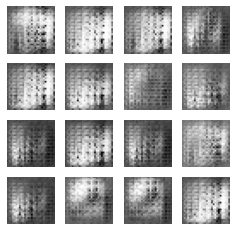

In [21]:
train(train_dataset, EPOCHS)

# Generate new images

In [ ]:
num_images = 10
noise = tf.random.normal([num_images, INPUT_LENGTH])
generated_images = gen(noise, training=False)*255.0

# View generated images

In [ ]:
plt.imshow(np.squeeze(generated_images[np.random.randint(num_images)]), cmap='gray')